# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель работы**

Построить модель для определения стоимости автомобиля. 

**Описание данных**

Набор данных находится в файле /datasets/autos.csv.

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак

- Price — цена (евро)

**План работы**

- Изучить данные, выявить пропущенные значения, дубликаты, аномалии и ненужные столбцы
- Провести предобработку данных
- Разделить выборку на тренировочную, валидационную и тестовую
- Выбрать для каждой из четырех моделей лучшие параметры
- Обучить четыре модели с выбранными параметрами и сравнить их по качеству и времени предсказания и обучения
- Лучшую модель проверить на тестовой выборке
- Написать вывод

## Подготовка данных

**1.1 Изучение данных**

In [2]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 40 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [3]:
# импорт необходимых библиотек 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

In [5]:
# загрузка данных
df = pd.read_csv('/datasets/autos.csv')
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

In [7]:
# проверим дубликаты
df.duplicated().sum()

4

In [8]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Вывод по пункту 1.1**
 
- Изучив данные, мы видим, что пропуски есть в столбцах VehicleType, Gearbox, Model, FuelType и Repaired.
- В данных есть дубликаты
- В столбцах RegistrationYear и Power есть аномальные значения. В столбцах RegistrationMonth и Price есть нулевые значения.
- Для обучения модели не несут ценности столбцы DateCrawled, DateCreated, LastSeen, NumberOfPictures, PostalCode, их можно удалить

In [9]:
print(df['DateCrawled'].sort_values(ascending=False))

90713     2016-04-07 14:36:58
339649    2016-04-07 14:36:56
301030    2016-04-07 14:36:55
53739     2016-04-07 14:36:54
204218    2016-04-07 14:36:53
                 ...         
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
176823    2016-03-05 14:06:24
220583    2016-03-05 14:06:23
329497    2016-03-05 14:06:22
Name: DateCrawled, Length: 354369, dtype: object


Следовательно, год регистрации не может превышать 2016

**1.2 Предобработка данных**

In [10]:
# удаление ненужных столбцов
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        316879 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            334536 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              334664 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           321474 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB
None


In [11]:
# удаление дубликатов
df = df.drop_duplicates()
df.duplicated().sum()

0

In [12]:
# посмотрим уникальные значения столбцов Gearbox, Repaired и Model
print(df['Gearbox'].value_counts())
print()
print(df['Repaired'].value_counts())
print()
print(df['Model'].value_counts())

# обработаем пропуски в столбцах Gearbox, Repaired наиболее популярными значениями, а в столбце Model значением unknown
df.fillna({'Gearbox':'manual', 'Repaired':'no', 'Model':'unknown'},inplace=True)
print()
print(df.info())

manual    248135
auto       61113
Name: Gearbox, dtype: int64

no     225970
yes     34429
Name: Repaired, dtype: int64

golf                  26444
other                 23231
3er                   18037
polo                  11934
corsa                 11381
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        1
Name: Model, Length: 250, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326826 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType        291577 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox            326826 non-null  object
 4   Power              326826 non-null  int64 
 5   Model              326826 non-null  object
 6   Kilometer          326826 non-n

In [13]:
# заменим пропуски в столбцах VehicleType и FuelType модой по каждой группе
for t in df['Brand'].unique():
    df.loc[(df['Brand']==t) & (df['VehicleType'].isna()), 'VehicleType'] = df.loc[(df['Brand']==t), 'VehicleType'].mode().values[0]
    df.loc[(df['Brand']==t) & (df['FuelType'].isna()), 'FuelType'] = df.loc[(df['Brand']==t), 'FuelType'].mode().values[0]
display(df.head(10))
print(df.info())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no
9,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 326826 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              326826 non-null  int64 
 1   VehicleType        326826 non-null  object
 2   RegistrationYear   326826 non-null  int64 
 3   Gearbox            326826 non-null  object
 4   Power              326826 non-null  int64 
 5   Model              326826 non-null  object
 6   Kilometer          326826 non-null  int64 
 7   RegistrationMonth  326826 non-null  int64 
 8   FuelType           326826 non-null  object
 9   Brand              326826 non-null  object
 10  Repaired           326826 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.9+ MB
None


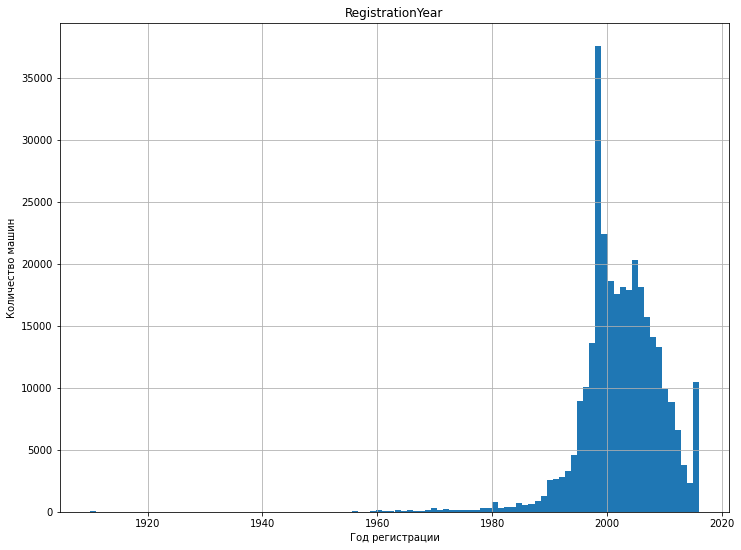

In [14]:
# избавимся от аномалий в столбце RegistrationYear
df = df.query('1899 < RegistrationYear < 2017')
df['RegistrationYear'].hist(bins=100, figsize=(12,9))
df['RegistrationYear'].describe()
plt.xlabel('Год регистрации')
plt.ylabel('Количество машин')
plt.title('RegistrationYear')
plt.show()

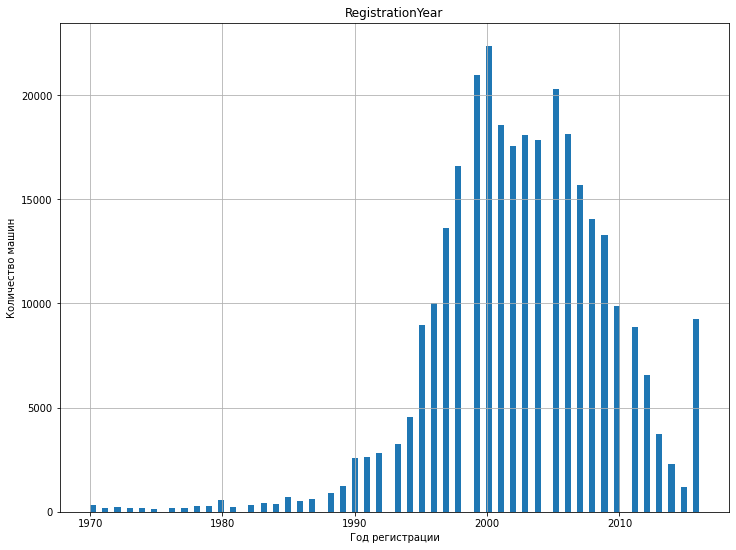

In [15]:
# есть смысл смотреть с 1970 года
df = df.query('1969 < RegistrationYear < 2017')
df['RegistrationYear'].hist(bins=100, figsize=(12,9))
df['RegistrationYear'].describe()
plt.xlabel('Год регистрации')
plt.ylabel('Количество машин')
plt.title('RegistrationYear')
plt.show()

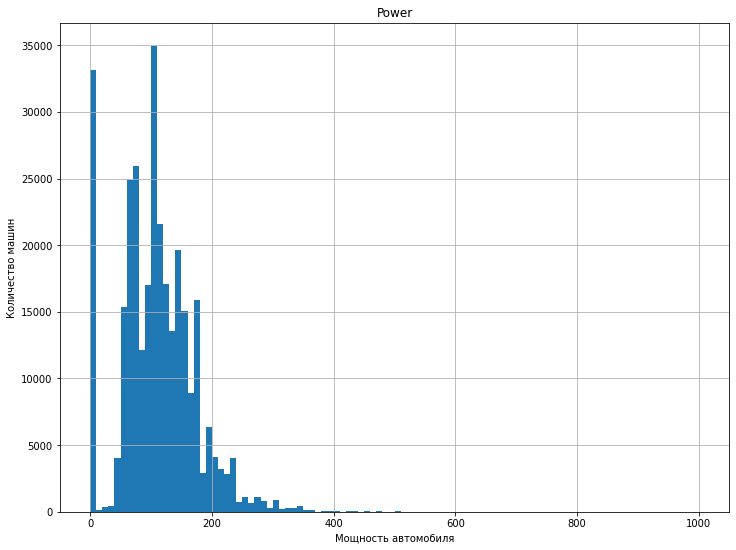

In [16]:
# избавимся от аномалий в столбце Power, отсечем те, у которых мощность больше 1000 л.с.
df = df.query('Power < 1001')
df['Power'].hist(bins=100, figsize=(12,9))
df['Power'].describe()
plt.xlabel('Мощность автомобиля')
plt.ylabel('Количество машин')
plt.title('Power')
plt.show()

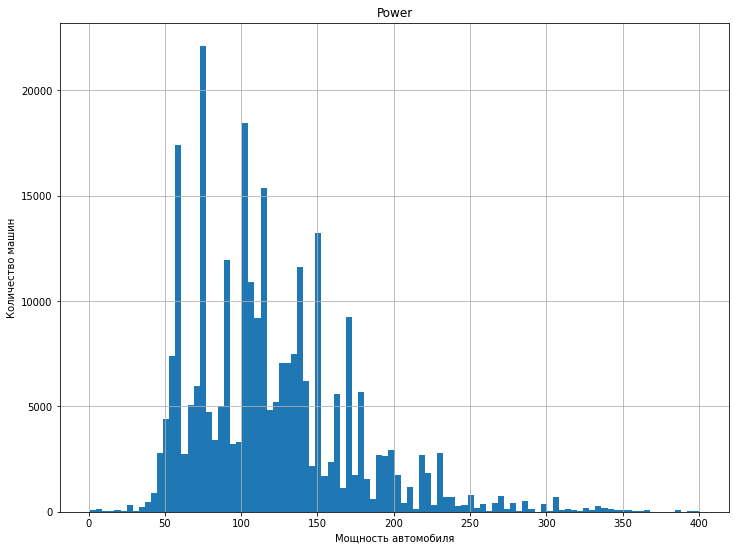

In [17]:
# уберем нулевые значения и больше 400 л.с.
df = df.query('0 < Power < 401')
df['Power'].hist(bins=100, figsize=(12,9))
df['Power'].describe()
plt.xlabel('Мощность автомобиля')
plt.ylabel('Количество машин')
plt.title('Power')
plt.show()

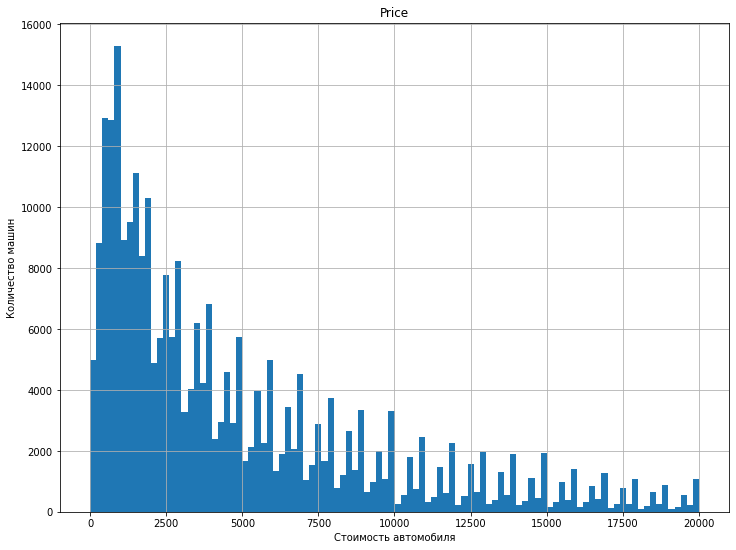

In [18]:
# избавимся от аномалий в столбце Price, отсечем нулевые значения
df = df.query('Price > 0')
df['Price'].hist(bins=100, figsize=(12,9))
df['Price'].describe()
plt.xlabel('Стоимость автомобиля')
plt.ylabel('Количество машин')
plt.title('Price')
plt.show()

In [19]:
# проверим, сколько данных осталось
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272411 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              272411 non-null  int64 
 1   VehicleType        272411 non-null  object
 2   RegistrationYear   272411 non-null  int64 
 3   Gearbox            272411 non-null  object
 4   Power              272411 non-null  int64 
 5   Model              272411 non-null  object
 6   Kilometer          272411 non-null  int64 
 7   RegistrationMonth  272411 non-null  int64 
 8   FuelType           272411 non-null  object
 9   Brand              272411 non-null  object
 10  Repaired           272411 non-null  object
dtypes: int64(5), object(6)
memory usage: 24.9+ MB
None


В процессе предобработки данных было удалено около 23% объектов

**Вывод по пункту 1.2**

В ходе предобработки данных было проделано следующее:
- удалены ненужные столбцы
- удалены дубликаты
- обработали пропуски в столбцах Gearbox, Repaired наиболее популярными значениями, а в столбце Model значением unknown
- заменили пропуски в столбцах VehicleType и FuelType модой по каждой группе
- избавились от аномалий в столбце RegistrationYear; оставили значения от 1970 до 2016 года
- избавились от аномалий в столбце Power; отсекли нулевые значения и те, у которых мощность больше 400 л.с.
- избавились от аномалий в столбце Price, отсекли нулевые значения

Было удалено около 23% объектов. Данные готовы к работе 

## Обучение моделей

Для обучения выберем следующие модели:

- LinearRegression
- DecisionTreeRegressor
- CatBoostRegressor
- LGBMRegressor

In [19]:
# отделим целевой признак от остальных признаков
features = df.drop('Price', axis=1)
target = df['Price']

In [20]:
# разобьем данные на обучающую, валидационную и тестовую выборки
features_train, features_tmp, target_train, target_tmp = train_test_split(features, target, test_size = 0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_tmp, target_tmp, test_size = 0.5, random_state=12345)

In [21]:
# OHE-кодирование
cat_columns = ['VehicleType', 'Gearbox', 'FuelType','Brand','Model', 'Repaired']
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

ohe_enc = OneHotEncoder(drop = 'first', handle_unknown='ignore')
ohe_enc.fit(features_train[cat_columns])
new_columns = ohe_enc.get_feature_names_out(cat_columns)

features_train_ohe = pd.DataFrame(ohe_enc.transform(features_train[cat_columns]).toarray(), 
                            columns = new_columns, index = features_train.index)
features_train_ohe = features_train_ohe.join(features_train[numeric])


features_valid_ohe = pd.DataFrame(ohe_enc.transform(features_valid[cat_columns]).toarray(), 
                            columns = new_columns, index = features_valid.index)
features_valid_ohe = features_valid_ohe.join(features_valid[numeric])

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [22]:
# порядковое кодирование
encoder = OrdinalEncoder()

cat_features_train = features_train[cat_columns]
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train), columns=cat_features_train.columns, index=cat_features_train.index)
features_train_ordinal = features_train.copy()
for column in cat_columns:
    features_train_ordinal[column] = cat_features_train[column]
    
cat_features_valid = features_valid[cat_columns]
cat_features_valid = pd.DataFrame(encoder.fit_transform(cat_features_valid), columns=cat_features_valid.columns, index=cat_features_valid.index)
features_valid_ordinal = features_valid.copy()
for column in cat_columns:
    features_valid_ordinal[column] = cat_features_valid[column]

In [23]:
print(features_train_ohe.shape)
print(features_train_ordinal.shape)
print(features_valid_ohe.shape)
print(features_valid_ordinal.shape)

(163446, 306)
(163446, 10)
(54482, 306)
(54482, 10)


**2.1 LinearRegression**

In [24]:
# обучение модели Линейной регрессии с помощью кроссвалидации без масштабирования
model_lin_1 = LinearRegression()
cross_score = (cross_val_score(model_lin_1, features_train_ohe, target_train, cv=5, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE LinearRegression =', cross_score)

Mean RMSE LinearRegression = 2573.684146415363


In [25]:
# для масштабирования нужны количественные переменные
features_train_scaller = features_train_ohe.copy()
features_valid_scaller = features_valid_ohe.copy()

# чтобы не появлялось предупреждение
pd.options.mode.chained_assignment = None

# преобразование обучающей выборки
scaler = StandardScaler()
scaler.fit(features_train_scaller[numeric])
features_train_scaller[numeric] = scaler.transform(features_train_scaller[numeric])
features_valid_scaller[numeric] = scaler.transform(features_valid_scaller[numeric])

In [26]:
# обучение модели Линейной регрессии с помощью кроссвалидации с масштабированием
model_lin_2 = LinearRegression()
cross_score_scaller = (cross_val_score(model_lin_2, features_train_scaller, target_train, cv=5, scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE LinearRegression =', cross_score_scaller)

Mean RMSE LinearRegression = 2573.684146415242


**Вывод по пункту 2.1**

Точность модели с масштабированием немного лучше

**2.2 DecisionTreeRegressor**

In [27]:
# рассмотрим эту модель на ОНЕ-кодировании
model_tree_1 = DecisionTreeRegressor()
max_depth_list_1 = [x for x in range(1, 31)]
hyperparams_1 = [{'criterion':['squared_error'], 'max_depth':max_depth_list_1, 'random_state':[12345]}]
score_tree_1 = GridSearchCV(model_tree_1, hyperparams_1, scoring='neg_mean_squared_error')
score_tree_1.fit(features_train_ohe, target_train)
print("Best parameters set found on development set:")
print()
print(score_tree_1.best_params_)
print()
print("Grid scores on development set:")
print()
means = score_tree_1.cv_results_['mean_test_score']
for mean, params in zip(means, score_tree_1.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
cv_RMSE_1 = (max(means)*-1) ** 0.5
print()
print('Best RMSE DecisionTreeRegressor =', cv_RMSE_1)

Best parameters set found on development set:

{'criterion': 'squared_error', 'max_depth': 14, 'random_state': 12345}

Grid scores on development set:

3641.453908 for {'criterion': 'squared_error', 'max_depth': 1, 'random_state': 12345}
3176.927907 for {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 12345}
2907.994083 for {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 12345}
2576.277867 for {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 12345}
2401.229169 for {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
2248.726185 for {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 12345}
2151.703665 for {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 12345}
2072.685420 for {'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}
2014.922781 for {'criterion': 'squared_error', 'max_depth': 9, 'random_state': 12345}
1971.019737 for {'criterion': 'squared_error', 'max_depth': 10, 'random_st

In [28]:
# рассмотрим эту модель на порядковом кодировании
model_tree_2 = DecisionTreeRegressor()
max_depth_list_2 = [i for i in range(1, 31)]
hyperparams_2 = [{'criterion':['squared_error'], 'max_depth':max_depth_list_2, 'random_state':[12345]}]
score_tree_2 = GridSearchCV(model_tree_2, hyperparams_2, scoring='neg_mean_squared_error')
score_tree_2.fit(features_train_ordinal, target_train)
print("Best parameters set found on development set:")
print()
print(score_tree_2.best_params_)
print()
print("Grid scores on development set:")
print()
means_2 = score_tree_2.cv_results_['mean_test_score']
for mean_2, params_2 in zip(means_2, score_tree_2.cv_results_['params']):
    print("%0.6f for %r"% ((mean_2*-1)** 0.5, params_2))
cv_RMSE_2 = (max(means_2)*-1) ** 0.5
print()
print('Best RMSE DecisionTreeRegressor =', cv_RMSE_2)

Best parameters set found on development set:

{'criterion': 'squared_error', 'max_depth': 12, 'random_state': 12345}

Grid scores on development set:

3641.453908 for {'criterion': 'squared_error', 'max_depth': 1, 'random_state': 12345}
3176.927907 for {'criterion': 'squared_error', 'max_depth': 2, 'random_state': 12345}
2907.994083 for {'criterion': 'squared_error', 'max_depth': 3, 'random_state': 12345}
2577.672356 for {'criterion': 'squared_error', 'max_depth': 4, 'random_state': 12345}
2397.883512 for {'criterion': 'squared_error', 'max_depth': 5, 'random_state': 12345}
2252.563958 for {'criterion': 'squared_error', 'max_depth': 6, 'random_state': 12345}
2157.670523 for {'criterion': 'squared_error', 'max_depth': 7, 'random_state': 12345}
2076.628685 for {'criterion': 'squared_error', 'max_depth': 8, 'random_state': 12345}
2017.365857 for {'criterion': 'squared_error', 'max_depth': 9, 'random_state': 12345}
1971.868263 for {'criterion': 'squared_error', 'max_depth': 10, 'random_st

**Вывод по пункту 2.2**

С ОНЕ-кодированием глубиной 14 модель DecisionTreeRegressor показала лучшую точность.

**2.3 CatBoostRegressor**

In [29]:
# модель CatBoostRegressor 
model_catboost = CatBoostRegressor()
hyperparams = [{'learning_rate':[0.1, 0.3, 0.5, 0.7, 0.9], 'random_state':[12345], 'verbose':[False]}]
score_catboost = GridSearchCV(model_catboost, hyperparams, scoring='neg_mean_squared_error')
score_catboost.fit(features_train_ordinal, target_train)
print("Best parameters set found on development set:")
print()
print(score_catboost.best_params_)
print()
print("Grid scores on development set:")
print()
means_3 = score_catboost.cv_results_['mean_test_score']
for mean_3, params_3 in zip(means_3, score_catboost.cv_results_['params']):
    print("%0.6f for %r"% ((mean_3*-1)** 0.5, params_3))
    print()
cv_RMSE_3 = (max(means_3)*-1) ** 0.5
print()
print('Best RMSE CatBoostRegressor =', cv_RMSE_3)

Best parameters set found on development set:

{'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}

Grid scores on development set:

1595.159039 for {'learning_rate': 0.1, 'random_state': 12345, 'verbose': False}

1577.789926 for {'learning_rate': 0.3, 'random_state': 12345, 'verbose': False}

1600.628536 for {'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}

1625.816219 for {'learning_rate': 0.7, 'random_state': 12345, 'verbose': False}

1658.931039 for {'learning_rate': 0.9, 'random_state': 12345, 'verbose': False}


Best RMSE CatBoostRegressor = 1577.789926026762


**Вывод по пункту 2.3**

Лучшую точность показала модель с параметром learning_rate = 0.3

**2.4 LGBMRegressor**

In [30]:
# модель LGBMRegressor с параметрами
model_lgbm = LGBMRegressor()
hyperparams = [{'num_leaves':[31, 100, 200], 'learning_rate':[0.1, 0.4, 0.7], 'random_state':[12345]}]
score_lgbm = GridSearchCV(model_lgbm, hyperparams, scoring='neg_mean_squared_error')
score_lgbm.fit(features_train_ordinal, target_train)
print("Best parameters set found on development set:")
print()
print(score_lgbm.best_params_)
print()
print("Grid scores on development set:")
print()
means_4 = score_lgbm.cv_results_['mean_test_score']
for mean_4, params_4 in zip(means_4, score_lgbm.cv_results_['params']):
    print("%0.6f for %r"% ((mean_4*-1)** 0.5, params_4))
print()
cv_RMSE_4 = (max(means_4)*-1) ** 0.5
print()
print('Best RMSE LGBMRegressor =', cv_RMSE_4)

Best parameters set found on development set:

{'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}

Grid scores on development set:

1672.422537 for {'learning_rate': 0.1, 'num_leaves': 31, 'random_state': 12345}
1602.409834 for {'learning_rate': 0.1, 'num_leaves': 100, 'random_state': 12345}
1578.425626 for {'learning_rate': 0.1, 'num_leaves': 200, 'random_state': 12345}
1624.733051 for {'learning_rate': 0.4, 'num_leaves': 31, 'random_state': 12345}
1612.432032 for {'learning_rate': 0.4, 'num_leaves': 100, 'random_state': 12345}
1619.716524 for {'learning_rate': 0.4, 'num_leaves': 200, 'random_state': 12345}
1662.074498 for {'learning_rate': 0.7, 'num_leaves': 31, 'random_state': 12345}
1693.897180 for {'learning_rate': 0.7, 'num_leaves': 100, 'random_state': 12345}
1718.851792 for {'learning_rate': 0.7, 'num_leaves': 200, 'random_state': 12345}


Best RMSE LGBMRegressor = 1578.4256263556276


**Вывод по пункту 2.4**
Лучшую точность показала модель с параметром learning_rate = 0.1 и num_leaves = 200

## Анализ моделей

Проведем обучение на каждой модели с лучшими гиперпараметрами и определим время обучения и предсказания

**3.1 LinearRegression**

In [31]:
%%time

model_lin = LinearRegression()
model_lin.fit(features_train_scaller, target_train)

CPU times: user 13.9 s, sys: 7.71 s, total: 21.6 s
Wall time: 21.6 s


LinearRegression()

In [32]:
%%time

predict_lin = model_lin.predict(features_valid_scaller)

CPU times: user 70.9 ms, sys: 56.3 ms, total: 127 ms
Wall time: 126 ms


In [33]:
RMSE_lin = mean_squared_error(target_valid, predict_lin) ** 0.5
print('RMSE LinearRegression =', RMSE_lin)

RMSE LinearRegression = 2555.3519972959753


**3.2 DecisionTreeRegressor**

In [34]:
%%time
model_tree = DecisionTreeRegressor(max_depth=14, random_state=12345) 
model_tree.fit(features_train_ohe, target_train)

CPU times: user 4.18 s, sys: 157 ms, total: 4.34 s
Wall time: 4.34 s


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [35]:
%%time
predict_tree = model_tree.predict(features_valid_ohe)

CPU times: user 66.9 ms, sys: 55.4 ms, total: 122 ms
Wall time: 127 ms


In [36]:
RMSE_tree = mean_squared_error(target_valid, predict_tree) ** 0.5
print('RMSE DecisionTreeRegressor =', RMSE_tree)

RMSE DecisionTreeRegressor = 1897.3461862824213


**3.3 CatBoostRegressor**

In [37]:
%%time
model_catboost = CatBoostRegressor(learning_rate=0.3, random_state=12345, verbose=False) 
model_catboost.fit(features_train_ordinal, target_train)

CPU times: user 22.6 s, sys: 183 ms, total: 22.8 s
Wall time: 23.8 s


In [38]:
%%time
predict_catboost = model_catboost.predict(features_valid_ordinal)

CPU times: user 53.6 ms, sys: 85 µs, total: 53.6 ms
Wall time: 51.8 ms


In [39]:
RMSE_catboost = mean_squared_error(target_valid, predict_catboost) ** 0.5
print('RMSE CatBoostRegressor =', RMSE_catboost)

RMSE CatBoostRegressor = 1687.8949774841758


**3.4 LGBMRegressor**

In [40]:
%%time
model_lgbm = LGBMRegressor(learning_rate=0.1, num_leaves=200, random_state=12345)
model_lgbm.fit(features_train_ordinal, target_train)

CPU times: user 12.5 s, sys: 262 ms, total: 12.7 s
Wall time: 12.8 s


LGBMRegressor(num_leaves=200, random_state=12345)

In [41]:
%%time
predict_lgbm = model_lgbm.predict(features_valid_ordinal)

CPU times: user 667 ms, sys: 8.15 ms, total: 675 ms
Wall time: 612 ms


In [42]:
RMSE_lgbm = mean_squared_error(target_valid, predict_lgbm) ** 0.5
print('RMSE LGBMRegressor =', RMSE_lgbm)

RMSE LGBMRegressor = 1634.0714727014815


**3.5 Сводная таблица результатов**

In [47]:
index = ['LinearRegression','DecisionTreeRegressor on OHE features', 'CatBoostRegressor', 'LGBMRegressor']
data = {'RMSE':[RMSE_lin, RMSE_tree, RMSE_catboost, RMSE_lgbm],
        'Время обучения модели, сек':[21.6, 4.34, 23.8, 12.8],
        'Время предсказания модели, сек':[0.126, 0.127, 0.052, 0.612]}
data_score = pd.DataFrame(data=data, index=index)
data_score['Рейтинг RMSE'] = (data_score['RMSE'].min() / data_score['RMSE'])
data_score['Рейтинг времени обучения'] = (data_score['Время обучения модели, сек'].min() / data_score['Время обучения модели, сек'])
data_score['Рейтинг времени предсказания'] = (data_score['Время предсказания модели, сек'].min() / data_score['Время предсказания модели, сек'])
data_score

,RMSE,"Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания
LinearRegression,2555.351997,21.60,0.126,0.639470,0.200926,0.412698
DecisionTreeRegressor on OHE features,1897.346186,4.34,0.127,0.861241,1.000000,0.409449
CatBoostRegressor,1697.491425,23.80,0.052,0.962639,0.182353,1.000000
LGBMRegressor,1634.071473,12.80,0.612,1.000000,0.339062,0.084967


**Вывод по пункту 3**

Сравнивая результаты в сводной таблице, получаем следующее:
- для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor on OHE features
- если важна точность и есть время, то лучше справится LGBMRegressor
- CatBoostRegressor показал хорошую точность и время предсказания самое лучшее, но дольше обучается

По точности  и с небольшим временем предсказания лучше оказался CatBoostRegressor, поэтому его проверим на тестовой выборке

In [48]:
# кодирование тестовой выборки
cat_features_test = features_test[cat_columns]
cat_features_test = pd.DataFrame(encoder.fit_transform(cat_features_test), columns=cat_features_test.columns, index=cat_features_test.index)
features_test_ordinal = features_test.copy()
for column in cat_columns:
    features_test_ordinal[column] = cat_features_test[column]

In [49]:
%%time

# проверка финальной модели на тестовой выборке
predict_catboost = model_catboost.predict(features_test_ordinal)

CPU times: user 58.8 ms, sys: 0 ns, total: 58.8 ms
Wall time: 56.8 ms


In [50]:
RMSE_catboost = mean_squared_error(target_test, predict_catboost) ** 0.5
print('RMSE CatBoostRegressor =', RMSE_catboost)

RMSE CatBoostRegressor = 1697.4914249804772


На тестовой выборке финальная модель показала себя также хорошо

**Общий вывод**

1. В ходе изучения данных было получено следующее:

- Пропуски есть в столбцах VehicleType, Gearbox, Model, FuelType и Repaired.
- В данных есть дубликаты
- В столбцах RegistrationYear и Power есть аномальные значения. В столбцах RegistrationMonth и Price есть нулевые значения.
- Для обучения модели не несут ценности столбцы DateCrawled, DateCreated, LastSeen, NumberOfPictures, PostalCode, их можно удалить

2. В ходе предобработки данных было проделано следующее:

- удалены ненужные столбцы
- удалены дубликаты
- обработали пропуски в столбцах Gearbox, Repaired наиболее популярными значениями, а в столбце Model значением unknown
- заменили пропуски в столбцах VehicleType и FuelType модой по каждой группе
- избавились от аномалий в столбце RegistrationYear; оставили значения от 1970 до 2016 года
- избавились от аномалий в столбце Power; отсекли нулевые значения и те, у которых мощность больше 400 л.с.
- избавились от аномалий в столбце Price, отсекли нулевые значения

3. Подобрали лучшие параметры для четырех моделей:
- для LinearRegression рассмотрели ОНЕ-кодирование и ОЕ-кодирование, лучшая точность была у ОНЕ-кодирования
- для DecisionTreeRegressor также рассмотрели два вида кодирования и выбрали глубину, лучший результат получили при ОНЕ-кодировании с глубиной 14
- для CatBoostRegressor рассмотрели параметр learning_rate, лучший результат при learning_rate=0.3
- для LGBMRegressor рассмотрели параметры learning_rate и num_leaves, лучший результат при learning_rate=0.1 и num_leaves=200

4. Лучшие представители каждой модели обучили, нашли время обучения и предсказания и значение RMSE, полученные данные занесли в сводную таблицу.

Сравнив результаты в сводной таблице, получили следующее:
- для быстрых решений с хорошей точностью подойдет DecisionTreeRegressor on OHE features
- если важна точность и есть время, то лучше справится LGBMRegressor
- CatBoostRegressor показал хорошую точность и время предсказания самое лучшее, но дольше обучается

По двум показателям лучше оказался CatBoostRegressor, поэтому его проверили на тестовой выборке, на которой также получили хорошие результаты